# Imports and Reading Data

In [4]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np_utils
%matplotlib inline
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, concatenate, LeakyReLU
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from data_science_utils.vision.keras import *
from time import time
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno as msno
import re
from joblib import Parallel, delayed
from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils
from data_science_utils import nlp as nlp_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols
from random import sample

import more_itertools
from more_itertools import flatten
import ast
from sklearn.preprocessing import LabelEncoder

import gc
from sklearn.decomposition import PCA

import sys
import os
sys.path.append(os.getcwd())
from importlib import reload
import lib
reload(lib)
from lib import *

import warnings
warnings.filterwarnings('ignore')

reload(model_utils)
from data_science_utils.models import mean_absolute_percentage_error
from data_science_utils.models import median_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from more_itertools import flatten
import dill
from collections import Counter
import operator


<module 'lib' from '/home/ec2-user/SageMaker/ML_hackathon_2019/lib.py'>

<module 'data_science_utils.models' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/data_science_utils/models/__init__.py'>

# Data Preprocessing


In [2]:
jobs = 32

In [12]:
df = pd.read_csv("price_prediction/india-asins-processed.csv")
df["text"] = Parallel(n_jobs=jobs, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm_plain(df["text"].values))

df_train,df_test = train_test_split(df,test_size=0.2)


100%|██████████| 4305099/4305099 [05:23<00:00, 13306.64it/s]


In [13]:
df = None
del df

# Text Encoding
le_train,le_transform, le = get_text_le("text",vocab_size=50000)
_ = le_train(df_train)
df_train['text_encoded'] = le_transform(df_train)
df_test['text_encoded'] = le_transform(df_test)

# GL encoding
gl_le_train,gl_le_transform, gl_le = get_le(colname="gl")
_ = gl_le_train(df_train)
df_train['GL_encoded'] = gl_le_transform(df_train)
df_test['GL_encoded'] = gl_le_transform(df_test)


df_test = df_test[["gl","GL_encoded","text","text_encoded","price"]]
df_train = df_train[["gl","GL_encoded","text","text_encoded","price"]]
gc.collect()

  0%|          | 0/3444079 [00:00<?, ?it/s]

Total Words before Min frequency filtering 380591
Total Words after Min frequency filtering 128299


100%|██████████| 861020/861020 [00:21<00:00, 39399.69it/s]


28

In [14]:
df_train.shape
df_test.shape
np.sum(df_train['price']==0),np.sum(df_train['price']<1)
np.sum(df_test['price']==0),np.sum(df_test['price']<1)
df_train = df_train[df_train['price']>1]
df_test = df_test[df_test['price']>1]
df_train.shape
df_test.shape

(3444079, 5)

(861020, 5)

(26539, 28423)

(6763, 7220)

(3415635, 5)

(853793, 5)

In [15]:
glove = api.load("glove-twitter-50") 
ptr_glove = PreTrainedEmbeddingsTransformer(glove,size=50)

df_test['glove_encoded'] = list(ptr_glove.transform(df_test['text'].values))
df_train['glove_encoded'] = list(ptr_glove.transform(df_train['text'].values))

Fasttext Transforms start at: 2019-07-01 17:49:04.314877
Number of Unique Test Tokens for Fasttext transform 203351


100%|██████████| 853793/853793 [00:17<00:00, 47555.51it/s]


Fasttext Transforms done at: 2019-07-01 17:50:22.347945
Fasttext Transforms start at: 2019-07-01 17:50:41.721211
Number of Unique Test Tokens for Fasttext transform 376407


100%|██████████| 3415635/3415635 [01:13<00:00, 46534.10it/s]


Fasttext Transforms done at: 2019-07-01 17:55:48.036112


# Modelling

- We use embedding dimension of 50 through-out

In [16]:
def mape_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff)


In [17]:
# set parameters:
max_features = 50000
maxlen = 100
batch_size = 256
embedding_dims = 50
pretrained_dims = 50
filters = 256
kernel_size = 3
hidden_dims = 256

train,validation = df_train,df_test
x_train,x_train_pt,x_gl_train,y_train = train['text_encoded'].values,train['glove_encoded'].values,train['GL_encoded'].values,train['price'].values
x_test,x_test_pt,x_gl_test,y_test = validation['text_encoded'].values,validation['glove_encoded'].values,validation['GL_encoded'].values,validation['price'].values

train_gl_stats = train.groupby(["gl"])["price"].agg(['mean','std','min','max']).reset_index()
validation_gl_stats = validation[["gl"]].merge(train_gl_stats,on="gl",how="left")
validation_gl_stats = validation_gl_stats.fillna(validation_gl_stats.mean())

train_gl_stats = train[["gl"]].merge(train_gl_stats,on="gl",how="left")
train_gl_stats = train_gl_stats[['mean','min','max']].values
validation_gl_stats = validation_gl_stats[['mean','min','max']].values


In [35]:
x_train = np.stack(x_train, axis=0)
gc.collect()
x_train_pt = np.stack(x_train_pt, axis=0)
gc.collect()


In [ ]:
x_test = np.stack(x_test, axis=0)
gc.collect()
x_test_pt = np.stack(x_test_pt, axis=0)
gc.collect()

In [39]:

main_input = Input(shape=(maxlen,), dtype='int32', name='Text_Encoding')
embedding = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen,
                    name="Text_Embedding")(main_input)
pretrained_embedding_input = Input(shape=(maxlen,pretrained_dims), dtype='float32', name='Pretrained_Embedding')

vlayer0 = concatenate([embedding,pretrained_embedding_input])

vlayer1 = conv_layer(vlayer0,n_kernels=64,kernel_size=3,padding='valid')
vlayer1 = MaxPooling1D()(vlayer1)

vlayer2 = conv_layer(vlayer1,n_kernels=64,kernel_size=3,padding='same')
vlayer4 = MaxPooling1D(padding='same')(vlayer2)
vlayer = conv_layer(vlayer4,n_kernels=25,kernel_size=3,padding='same')
vlayer6 = GlobalMaxPooling1D()(vlayer)

vlayer3 = conv_layer(vlayer2,n_kernels=32,kernel_size=5,padding='same')
vlayer3 = SpatialDropout1D(0.05)(vlayer3)

vlayer5 = concatenate([vlayer3,vlayer2])
vlayer_out = GlobalAveragePooling1D()(vlayer5)
vlayer_out = concatenate([vlayer_out,vlayer6])



x = SpatialDropout1D(0.05)(embedding)
x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
x = SpatialDropout1D(0.05)(x)
# we use max pooling:

x = GlobalMaxPooling1D()(x)
auxiliary_input =  Input(shape=(1,), dtype='int32', name='GL_encoding')
aux = Embedding(len(gl_le.classes_),
                    8,
                    input_length=1,
                    name="GL_embedding")(auxiliary_input)
aux = Flatten()(aux)
aux = Dropout(0.05)(aux)

gl_stats_input =  Input(shape=(3,), dtype='float32', name='GL_stats')
gl_inputs = BatchNormalization()(gl_stats_input)
gl_inputs = Dropout(0.1)(gl_inputs)

gl_inputs = concatenate([gl_inputs,aux])
gl_inputs = Dense(8)(gl_inputs)

x = concatenate([vlayer_out,x,gl_inputs,vlayer6])

# We add a vanilla hidden layer:
x = Dense(hidden_dims)(x)
x = Dropout(0.1)(x)
x = Activation('relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
main_output = Dense(1)(x)

model = Model(inputs=[main_input, auxiliary_input, pretrained_embedding_input,gl_stats_input], outputs=[main_output])
visualizer = Model(inputs=[main_input, pretrained_embedding_input], outputs=vlayer)
embedder = Model(inputs=[main_input], outputs=embedding)

model.compile(loss=mape_error,
              optimizer='adam',
              metrics=['mean_squared_error',mape_error])

In [40]:
print("Param count = ", model.count_params())

model.fit([x_train,x_gl_train,x_train_pt,train_gl_stats], y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=([x_test,x_gl_test,x_test_pt,validation_gl_stats], y_test),
          shuffle=True)


Param count =  2692218
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3415635 samples, validate on 853793 samples
Epoch 1/5
3415635/3415635 [==============================] - 1053s 308us/step - loss: 37.2494 - mean_squared_error: 8377387.3477 - mape_error: 37.1939 - val_loss: 34.0903 - val_mean_squared_error: 7451215.0545 - val_mape_error: 34.0053
Epoch 2/5
3415635/3415635 [==============================] - 1048s 307us/step - loss: 32.4069 - mean_squared_error: 8185957.9086 - mape_error: 32.2974 - val_loss: 31.8714 - val_mean_squared_error: 7335592.5693 - val_mape_error: 31.7405
Epoch 3/5
3415635/3415635 [==============================] - 1049s 307us/step - loss: 30.4216 - mean_squared_error: 8070957.7861 - mape_error: 30.2713 - val_loss: 31.1027 - val_mean_squared_error: 7254486.2116 - val_mape_error: 30.9347
Epoch 4/5
3415635/3415635 [==============================] - 1051s 308us/step - loss: 29.0

In [42]:
def show_results(y_test,y_validation):
    mse = mean_squared_error(y_test,y_validation)
    mape = mean_absolute_percentage_error(y_test,y_validation)
    medape = median_absolute_percentage_error(y_test,y_validation)
    print("MSE = %.2f, MAPE = %.2f, MEDAPE = %.2f"%(mse,mape, medape))
    return (mse,mape, medape)

In [43]:
y_validation = model.predict([x_test,x_gl_test, x_test_pt,validation_gl_stats])
show_results(y_test,y_validation.reshape((-1)));


MSE = 7104527.32, MAPE = 29.70, MEDAPE = 20.00


# Inspecting the Model

## Error Inspection
- Error Distribution
- Actual Price vs Predicted Price Plot

[Reference](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

In [44]:
df_preds = pd.DataFrame({"actual":y_test,"prediction":y_validation.reshape((-1)),
                         })
df_preds['ape'] = 100*np.abs(df_preds['actual'] - df_preds['prediction'])/np.clip(np.abs(df_preds['actual']),1e-3,None)
df_preds['error'] = df_preds['prediction'] - df_preds['actual']



In [46]:
df_preds['error'].describe()

count    853793.000000
mean       -280.672815
std        2650.614706
min     -581791.574664
25%        -150.721040
50%         -32.829315
75%          19.679584
max        5889.412461
Name: error, dtype: float64

In [45]:
df_preds['ape'].describe()

count    853793.000000
mean         29.696292
std         117.200431
min           0.000093
25%           8.676259
50%          19.995226
75%          40.269717
max       90097.813164
Name: ape, dtype: float64

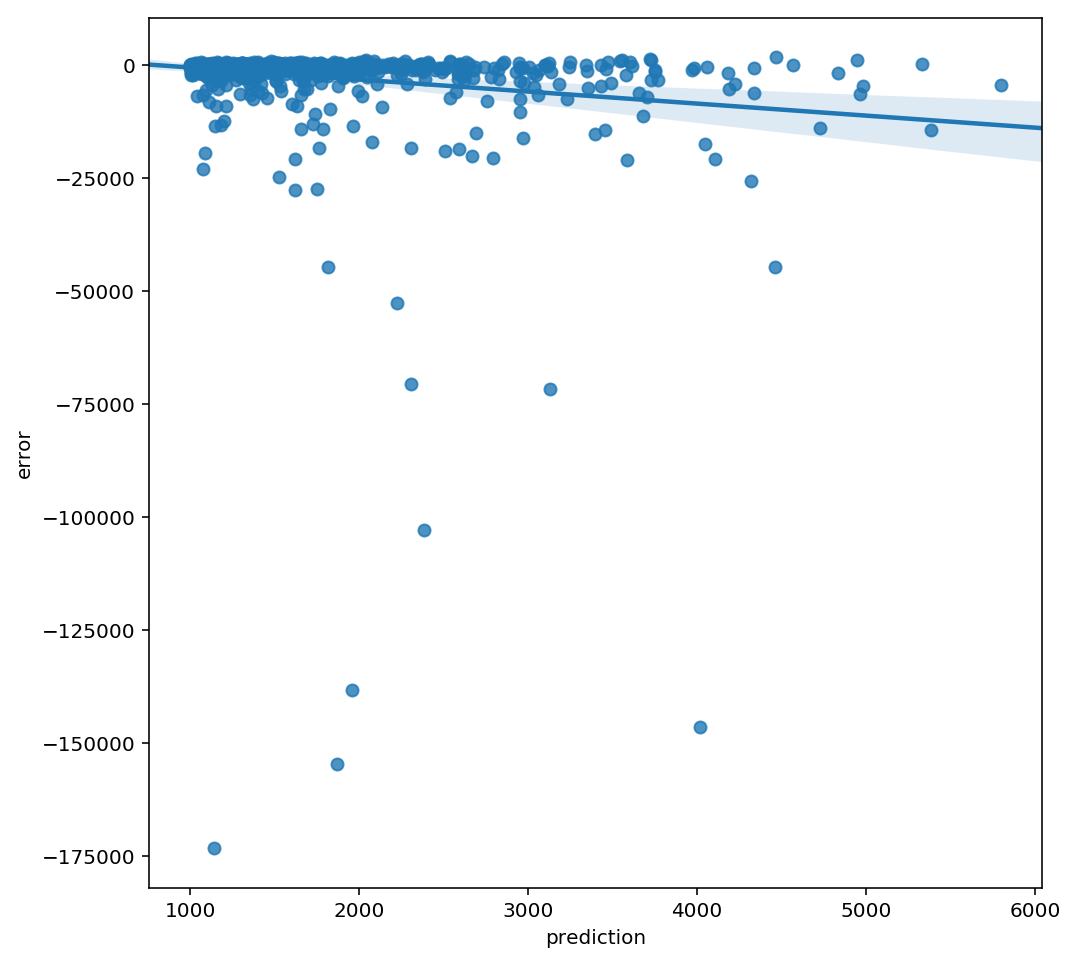

In [47]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(1, 1, 1)
data = df_preds[(df_preds["prediction"]>=1000)&(df_preds["prediction"]<=20000)]
sns.regplot(x='prediction',y='error',data=data.sample(1000),ax=ax)

(1000.0, 9999.1)


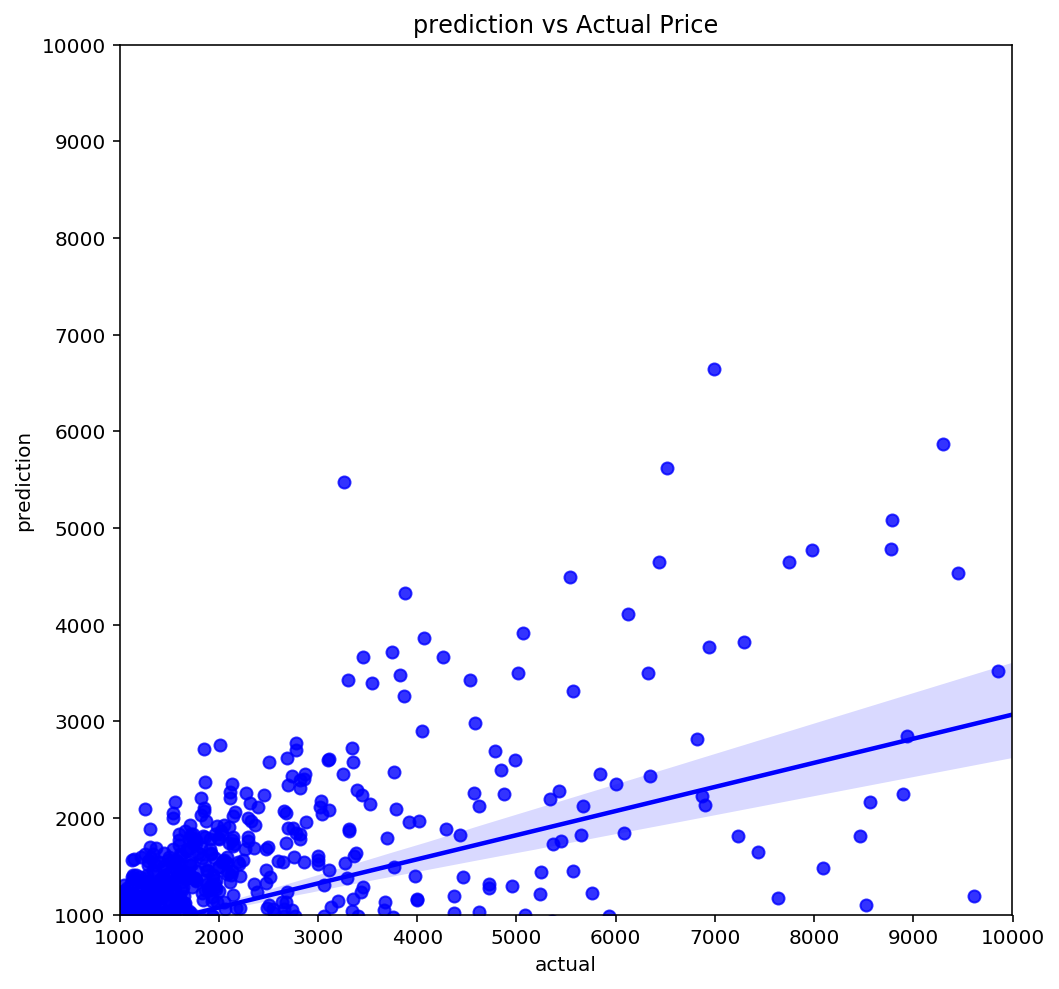

In [48]:
def actual_vs_other_column(column,actual_range):

    fig = plt.figure(figsize=(8,8));
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("%s vs Actual Price"%(column))
    rng = actual_range
    data = df_preds[(df_preds["actual"]>=rng[0])&(df_preds["actual"]<=rng[1])]
    plot_range = (data[['actual',column]].min().max(),data[['actual',column]].max().min())
    print(plot_range)
    sns.regplot(x="actual", y=column, data=data.sample(1000), color="b", ax = ax,fit_reg=True);
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.show()
actual_vs_other_column('prediction',(1000,10000))